In [209]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
import baltic as bt
import numpy as np
import pickle
from collections import defaultdict
import matplotlib.patheffects as path_effects

In [229]:
colors = pickle.load(open('./colors.p', 'rb'))
effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.4, foreground='black')] ## black text, white outl

collapsed_antigenic_tree_file = '../data/trees/annotated_collapsed_antigenic_tree.nexus'
collapsed_antigenic_tree = bt.loadNexus(collapsed_antigenic_tree_file, absoluteTime=False)

In [265]:
def plot_radial_tree(ll, ax):
    
    ##### Global setup #####
    branchWidth=3

    inwardSpace=-1.15 
    gap=0.95 
    circFrac=1.0
    startFrom=np.pi 
    
    controlDepth=ll.treeHeight
    baseCircle=2*np.pi*startFrom

    leaves = [k for k in ll.Objects if k.branchType=='leaf']
    leafCount=len(leaves) ## count leaves in the tree
    mostRecent = sorted(leaves, key = lambda k: k.height, reverse=True)[0].height
    maxwidth = max([k.traits['width'] if 'width' in k.traits else 1.0])
    
    ##### Legend setup #####
    ordered_clades = [k for k in ll.traverse_tree(include_all=True) if k.branchType=='leaf']
    legend_yvals = np.linspace(-1*ll.treeHeight/2., 1*ll.treeHeight/2., len(ordered_clades))
    legend_yvals = { k : yval for k,yval in zip(ordered_clades, legend_yvals)}
    
    ##### Plot each tree object #####
    n = 12
    for k in ll.Objects: 
        y=k.y 
        x=k.x
        xp=k.parent.x
        if x==None:
            x=0.0
        if xp==None:
            xp=x
        xc=inwardSpace+((mostRecent-x)/controlDepth)
        xpc=inwardSpace+((mostRecent-xp)/controlDepth)
        yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate
            
        ##### Assign color #####
        if k.traits.has_key('genotype') and k.traits['genotype'] in colors: ## if tree has PB1 trait - colour accordingly
            c=colors[k.traits['genotype']]
        elif k.traits.has_key('serotype'):
            c = colors[k.traits['serotype']]
        else:
            c = 'gray'
        
        if isinstance(k,bt.leaf): ## if leaf...
                        
            ##### Node width & label offset
            s = 50+k.traits['width']*50/maxwidth
            if k.traits['width'] > 40:
                offset = 0
            elif np.sin(yc)*xc > 0:
                offset = 0.1
            else:
                offset = -0.1
                
            ##### Plot and number node #####
            ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip, notice that coordinates that were y coordinates are now transformed with sin and cos and previous x coordinate is used to scale the circle up
            ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=1.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.text(np.sin(yc)*xc+offset,np.cos(yc)*xc,str(n), zorder=1000, ha='center', va='center',path_effects=effects)

            ##### Add to legend #####
            if 'genotype' in k.traits:
                label = k.traits['genotype'].replace('_', ' ')
            else:
                label = k.traits['serotype']
            legend_y = legend_yvals[k]
            ax.scatter(ll.treeHeight/2*1.3,legend_y,s=250,facecolor=c,edgecolor='none',zorder=11) 
            ax.scatter(ll.treeHeight/2*1.3,legend_y,s=1.8*250,facecolor='k',edgecolor='none',zorder=10) 
            ax.text(ll.treeHeight/2*1.3,legend_y, str(n), zorder=1000, ha='center', va='center', path_effects=effects, fontsize=10)
            ax.text(ll.treeHeight/2*1.4,legend_y, label, va='center')
            n -= 1
            
        elif isinstance(k,bt.node): ##if node.....
            yl=k.children[-1].y # pull and transform children coordinates
            yr=k.children[0].y 
            ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap 
            ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap 

            ybar=np.linspace(ycl,ycr,15) ## create a curved bar
            ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,color='gray',ls='-',zorder=9) ## plot curved bar at the base of a node
            
            if k.parent.index=='Root': ## Plot the root
                ax.scatter(np.sin(ybar[7])*xc, np.cos(ybar[7])*xc, c='k', s=50, zorder=15)

        ## plot ancestral branch
        ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,color='gray',ls='-',zorder=9) 
    
    ##### Add and label scale circles #####
    label_theta = 1.25*np.pi
    for r in [0.25, 0.50, 0.75, 1.0]:
        guide = patches.Circle((0,0), radius=r, ec='gray', fc=None, ls=':', fill=False)
        ax.add_patch(guide)
        if r < 0.5:
            label = ''
        elif r < 1.0:
            label = str(r)
        else:
            label = r'1 log $_2$'+'\ntiter unit'
        ax.text(r*np.sin(label_theta), r*np.cos(label_theta), label, rotation=-40, va='top', ha='center', color='gray')
        
    ##### Format figure #####
    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',size=0) ## no labels
    ax.tick_params(axis='y',size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_aspect(1) ## aspect set to 1 for proper circular plot
    ax.set_xlim(-1.1*ll.treeHeight/2., ll.treeHeight/2.*1.5)
    ax.set_ylim(-1.2*ll.treeHeight/2., 1.2*ll.treeHeight/2.)
    return ax

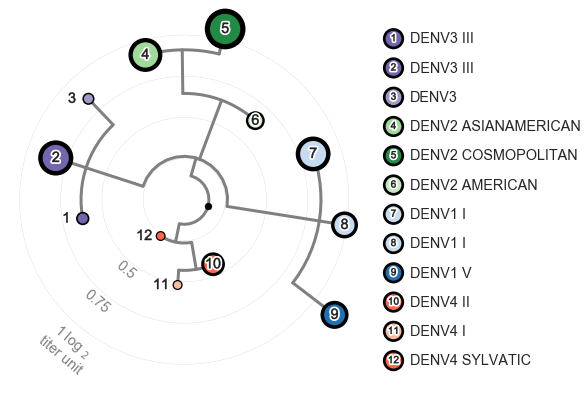

In [267]:
collapsed_antigenic_tree.drawTree()
sns.set(style='white', font_scale=1.2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5)) # quarter page

plot_radial_tree(collapsed_antigenic_tree, ax)

plt.savefig('./png/antigenic_tree.png', dpi=300, bbox_inches='tight')
plt.show()

In [272]:
def plot_tree(ll, ax):
    sns.set(style='white')

    max_width = max([k.traits['width'] for k in ll.Objects if 'width' in k.traits])
    branchWidth = 3

    for k in ll.Objects: # Plot objects
        x=k.x 
        y=k.y 

        xp=k.parent.x 
        yp=k.parent.y
        if x==None:
            x=0.0
        if xp==None:
            xp=x

        ## Color
        if 'genotype' in k.traits:
            genotype = k.traits['genotype']
            if k.traits['genotype'] in colors:
                c = colors[genotype]
            else:
                c = colors[k.traits['serotype']]
            label = genotype.replace('_', ' ')
        elif 'serotype' in k.traits:
            serotype = k.traits['serotype']
            c = colors[k.traits['serotype']]
            label = serotype
        else:
            c = 'darkgray'
            label = 'interserotype'

        z=10
        s = 500
        if 'width' in k.traits:
            s = s*k.traits['width']/max_width

        if label != 'interserotype':
            ax.scatter(x,y,s=s+10,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=(s+10)*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            if label.startswith('DENV1'):
                ax.text(x-0.1, y, label, ha='right', va='center')
            else:
                ax.text(x+0.1, y, label, ha='left', va='center')

        ax.plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)

    ax.plot([0,.5], [-2,-2], lw=branchWidth, color='darkgray', ls='-')
    ax.text(0.25,-1.9, '1-fold titer drop', va='bottom', ha='center')
    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',size=0) ## no labels
    ax.tick_params(axis='y',size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

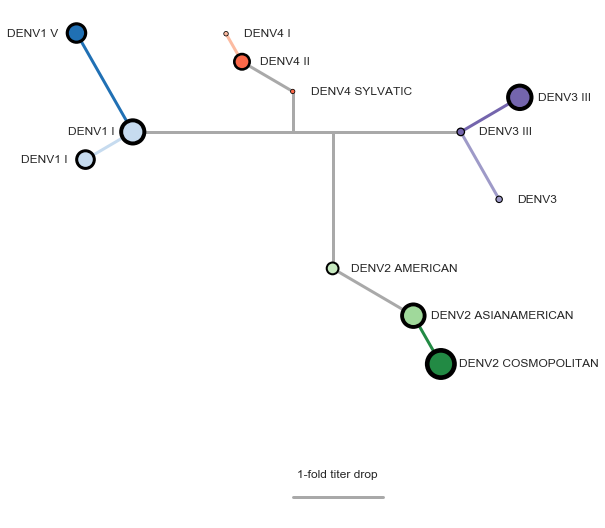

In [273]:
collapsed_antigenic_tree.drawUnrooted()
sns.set(style='white', font_scale=1.2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5)) # quarter page

plot_tree(collapsed_antigenic_tree, ax=ax)#, cmap=cmap)

plt.tight_layout()
plt.savefig('./png/antigenic_tree_supplement.png', dpi=300, bbox_inches='tight')
plt.show()